# lgb - hyperopt 데모 
* gridSearchCV(모든 조합 사용),RandomizedSearchCV(조합중 랜덤하게 사용_분포지정 가능)
* 선택 후 검증 결과를 가지고 이후 값 선택에 도움을 주는데 최적화되어 있다.  
* 모델 튜닝 라이브러리 방식 2가지  
  티피이_하이퍼&옵티(가우시안보다 빨라도 파라미터 증가에 따라 시간 급증. 예로 100번 돌림 오래 걸림)

## 라이브러리 import 및 설정

In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [16]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

val_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 1022
#seed : 1000,2000,3000 test

algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'
df = pd.read_csv(feature_file, index_col=0)

In [17]:
y = df[target_col].values[:320000]           #종속
df.drop(target_col, axis=1, inplace=True)    #독립을 위한 종속 제거
trn = df.iloc[:320000].values                #train을 위한 독립 320000개     
tst = df.iloc[320000:].values                #test을 위한 독립 80000개
feature_name = df.columns.tolist()           #독립변수 이름 리스트로 변환
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## 학습/검증 데이터 구분
**학습 후 모델의 예측/분류 정확도 계산을 위한 검증데이터 분리**

[Hold-out Validation]

In [18]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [19]:
params = {
    "objective": "multiclass",
    "n_estimators": 2000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}
#고정 파라미터

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [312, 241, 200, 127,256]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "num_iteration":hp.choice("num_iteration",[100,200,300,400,500,600,700])
}

#변경 파라미터_넓은 범위와 여러 파라미터 사용시 시간 급증 (주의)
#loguniform: 로그함수를 이용해 확률 분포 내에서의 값으로 test
#choice: 리스트 값 중 하나로 선택하여 test
#quniform: start와 stop사이에서 일정 간격으로 값을 주어 test

def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",#멀티클래스_로그 손실함수
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]
    #측정한 파라미터 중단됐을 때 최고의 성능점수

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=7, verbose=1)
# fn=최소화하고 싶은 함수와 파라미터(space), 
# trials=실행 객체변수, tpe.sugges=알고리즘 선택
# max_evals=서치 횟수 

hyperparams = space_eval(space, best)
#검색하여 나온 최적의 파라미터
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)
#업데이트된 파라미터

[LightGBM] [Warning]                                                                                                   
num_iterations is set=400, num_iteration=400 will be ignored. Current value: num_iterations=400                        
100%|█████████████████████████████████████████████████| 7/7 [09:34<00:00, 82.05s/trial, best loss: 0.16057435243532042]
{'objective': 'multiclass', 'n_estimators': 2000, 'subsample_freq': 1, 'random_state': 1022, 'n_jobs': -1, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.04878254203733923, 'num_iteration': 400, 'num_leaves': 312, 'subsample': 0.8}


## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.  
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [20]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [21]:
#93.2728% seed42
#93.3216% seed1022
#93.3150% 2000 n_es
#93.2675% 2022 seed
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
#(cv.split(),1)
# -  StratifiedKFold 경우, trn,y 독립과 종속(동일 분포를 위해) 인자
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    #확률로 예측값 초가화
    p_tst += clf.predict_proba(tst) / n_fold
    #평균 효과를 위해 먼저 폴드 개수만큼 나누어 초기화

training model for CV #1
[1]	valid_0's multi_logloss: 0.922329
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.864165
[3]	valid_0's multi_logloss: 0.815506
[4]	valid_0's multi_logloss: 0.771374
[5]	valid_0's multi_logloss: 0.734022
[6]	valid_0's multi_logloss: 0.698911
[7]	valid_0's multi_logloss: 0.664526
[8]	valid_0's multi_logloss: 0.632136
[9]	valid_0's multi_logloss: 0.605067
[10]	valid_0's multi_logloss: 0.57634
[11]	valid_0's multi_logloss: 0.551154
[12]	valid_0's multi_logloss: 0.531189
[13]	valid_0's multi_logloss: 0.510308
[14]	valid_0's multi_logloss: 0.489623
[15]	valid_0's multi_logloss: 0.470745
[16]	valid_0's multi_logloss: 0.455934
[17]	valid_0's multi_logloss: 0.439725
[18]	valid_0's multi_logloss: 0.422667
[19]	valid_0's multi_logloss: 0.408541
[20]	valid_0's multi_logloss: 0.393398
[21]	valid_0's multi_logloss: 0.381425
[22]	valid_0's multi_logloss: 0.36989
[23]	valid_0's multi_logloss: 0.360934
[24]	valid_0's multi_logloss

[207]	valid_0's multi_logloss: 0.158056
[208]	valid_0's multi_logloss: 0.158042
[209]	valid_0's multi_logloss: 0.158024
[210]	valid_0's multi_logloss: 0.158044
[211]	valid_0's multi_logloss: 0.158004
[212]	valid_0's multi_logloss: 0.157986
[213]	valid_0's multi_logloss: 0.157986
[214]	valid_0's multi_logloss: 0.158011
[215]	valid_0's multi_logloss: 0.158003
[216]	valid_0's multi_logloss: 0.158008
[217]	valid_0's multi_logloss: 0.157996
[218]	valid_0's multi_logloss: 0.158008
[219]	valid_0's multi_logloss: 0.157982
[220]	valid_0's multi_logloss: 0.157968
[221]	valid_0's multi_logloss: 0.157968
[222]	valid_0's multi_logloss: 0.157973
[223]	valid_0's multi_logloss: 0.157975
[224]	valid_0's multi_logloss: 0.157985
[225]	valid_0's multi_logloss: 0.157993
[226]	valid_0's multi_logloss: 0.157995
[227]	valid_0's multi_logloss: 0.157963
[228]	valid_0's multi_logloss: 0.157951
[229]	valid_0's multi_logloss: 0.157967
[230]	valid_0's multi_logloss: 0.157971
[231]	valid_0's multi_logloss: 0.157989


[170]	valid_0's multi_logloss: 0.160934
[171]	valid_0's multi_logloss: 0.160883
[172]	valid_0's multi_logloss: 0.160838
[173]	valid_0's multi_logloss: 0.160775
[174]	valid_0's multi_logloss: 0.160756
[175]	valid_0's multi_logloss: 0.160714
[176]	valid_0's multi_logloss: 0.160689
[177]	valid_0's multi_logloss: 0.160664
[178]	valid_0's multi_logloss: 0.160621
[179]	valid_0's multi_logloss: 0.160588
[180]	valid_0's multi_logloss: 0.160563
[181]	valid_0's multi_logloss: 0.160545
[182]	valid_0's multi_logloss: 0.160525
[183]	valid_0's multi_logloss: 0.160508
[184]	valid_0's multi_logloss: 0.16051
[185]	valid_0's multi_logloss: 0.16049
[186]	valid_0's multi_logloss: 0.160474
[187]	valid_0's multi_logloss: 0.160445
[188]	valid_0's multi_logloss: 0.16043
[189]	valid_0's multi_logloss: 0.160405
[190]	valid_0's multi_logloss: 0.160399
[191]	valid_0's multi_logloss: 0.16039
[192]	valid_0's multi_logloss: 0.160398
[193]	valid_0's multi_logloss: 0.160329
[194]	valid_0's multi_logloss: 0.160319
[195

[142]	valid_0's multi_logloss: 0.162511
[143]	valid_0's multi_logloss: 0.162406
[144]	valid_0's multi_logloss: 0.162351
[145]	valid_0's multi_logloss: 0.162272
[146]	valid_0's multi_logloss: 0.162104
[147]	valid_0's multi_logloss: 0.162005
[148]	valid_0's multi_logloss: 0.16185
[149]	valid_0's multi_logloss: 0.161691
[150]	valid_0's multi_logloss: 0.161651
[151]	valid_0's multi_logloss: 0.161579
[152]	valid_0's multi_logloss: 0.161436
[153]	valid_0's multi_logloss: 0.161383
[154]	valid_0's multi_logloss: 0.161327
[155]	valid_0's multi_logloss: 0.161221
[156]	valid_0's multi_logloss: 0.161136
[157]	valid_0's multi_logloss: 0.161085
[158]	valid_0's multi_logloss: 0.161034
[159]	valid_0's multi_logloss: 0.160995
[160]	valid_0's multi_logloss: 0.160989
[161]	valid_0's multi_logloss: 0.160912
[162]	valid_0's multi_logloss: 0.160889
[163]	valid_0's multi_logloss: 0.16086
[164]	valid_0's multi_logloss: 0.160811
[165]	valid_0's multi_logloss: 0.160814
[166]	valid_0's multi_logloss: 0.160763
[1

[128]	valid_0's multi_logloss: 0.165557
[129]	valid_0's multi_logloss: 0.165425
[130]	valid_0's multi_logloss: 0.165301
[131]	valid_0's multi_logloss: 0.165141
[132]	valid_0's multi_logloss: 0.165054
[133]	valid_0's multi_logloss: 0.164903
[134]	valid_0's multi_logloss: 0.164762
[135]	valid_0's multi_logloss: 0.164682
[136]	valid_0's multi_logloss: 0.164628
[137]	valid_0's multi_logloss: 0.164494
[138]	valid_0's multi_logloss: 0.164426
[139]	valid_0's multi_logloss: 0.164362
[140]	valid_0's multi_logloss: 0.164273
[141]	valid_0's multi_logloss: 0.164184
[142]	valid_0's multi_logloss: 0.164114
[143]	valid_0's multi_logloss: 0.164004
[144]	valid_0's multi_logloss: 0.163937
[145]	valid_0's multi_logloss: 0.163889
[146]	valid_0's multi_logloss: 0.163733
[147]	valid_0's multi_logloss: 0.1637
[148]	valid_0's multi_logloss: 0.163584
[149]	valid_0's multi_logloss: 0.163416
[150]	valid_0's multi_logloss: 0.163317
[151]	valid_0's multi_logloss: 0.16323
[152]	valid_0's multi_logloss: 0.163108
[15

[100]	valid_0's multi_logloss: 0.171032
[101]	valid_0's multi_logloss: 0.170679
[102]	valid_0's multi_logloss: 0.170283
[103]	valid_0's multi_logloss: 0.170048
[104]	valid_0's multi_logloss: 0.169629
[105]	valid_0's multi_logloss: 0.169254
[106]	valid_0's multi_logloss: 0.169095
[107]	valid_0's multi_logloss: 0.168783
[108]	valid_0's multi_logloss: 0.168461
[109]	valid_0's multi_logloss: 0.168283
[110]	valid_0's multi_logloss: 0.168101
[111]	valid_0's multi_logloss: 0.167727
[112]	valid_0's multi_logloss: 0.167359
[113]	valid_0's multi_logloss: 0.167081
[114]	valid_0's multi_logloss: 0.166727
[115]	valid_0's multi_logloss: 0.166432
[116]	valid_0's multi_logloss: 0.166328
[117]	valid_0's multi_logloss: 0.166074
[118]	valid_0's multi_logloss: 0.165774
[119]	valid_0's multi_logloss: 0.165561
[120]	valid_0's multi_logloss: 0.165364
[121]	valid_0's multi_logloss: 0.16523
[122]	valid_0's multi_logloss: 0.165048
[123]	valid_0's multi_logloss: 0.16495
[124]	valid_0's multi_logloss: 0.164795
[1

In [22]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')
#93.3319%

93.3319%


[stacking 사용을 위해 p_val,p_tst 저장]

In [23]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화
* 여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

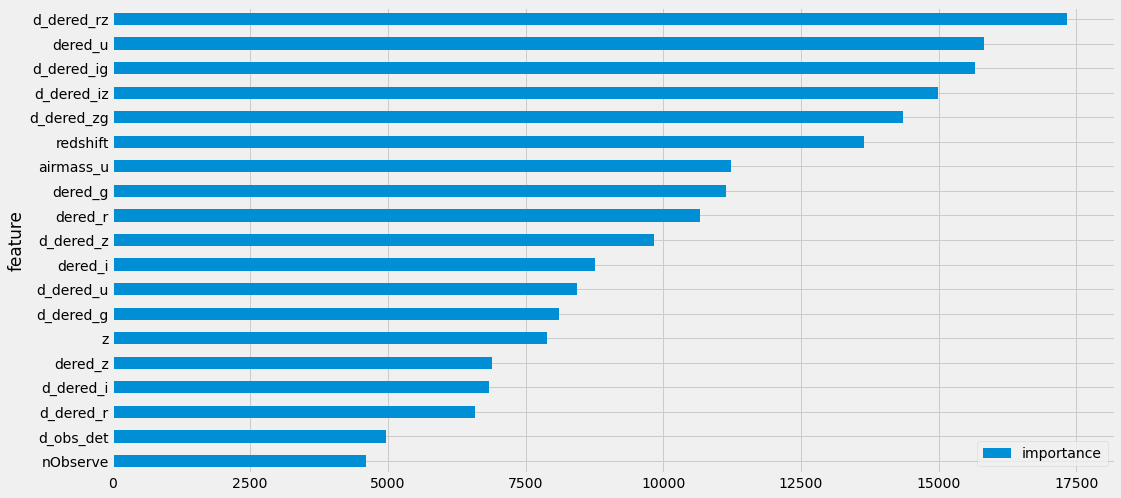

In [24]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [25]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)

(80000, 1)


In [26]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [80]:
sub.to_csv(sub_file)